In [290]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [291]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')


In [292]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [293]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [294]:
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

In [295]:
print(test_data.shape)

(418, 11)


In [296]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [297]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

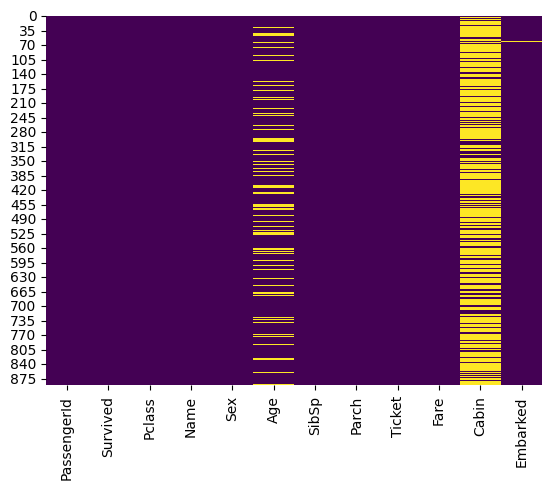

In [298]:
sns.heatmap(train_data.isnull(), cmap='viridis', cbar=False)
plt.show()

In [299]:
test_data.isnull().sum()
    

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

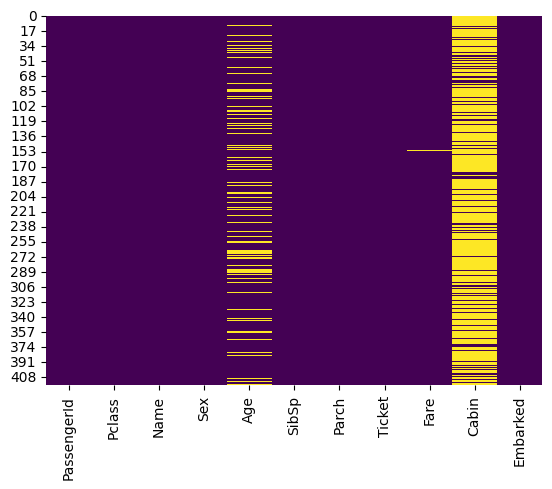

In [300]:
# Visualize missing data
sns.heatmap(test_data.isnull(), cmap='viridis', cbar=False)
plt.show()

In [301]:
# Feature engineering
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1


In [302]:
train_data['IsAlone'] = 0
train_data.loc[train_data['FamilySize'] == 1, 'IsAlone'] = 1
test_data['IsAlone'] = 0
test_data.loc[test_data['FamilySize'] == 1, 'IsAlone'] = 1

In [303]:
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [304]:
train_data['Title'] = train_data['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train_data['Title'] = train_data['Title'].replace('Mlle', 'Miss')
train_data['Title'] = train_data['Title'].replace('Ms', 'Miss')
train_data['Title'] = train_data['Title'].replace('Mme', 'Mrs')


In [305]:
test_data['Title'] = test_data['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test_data['Title'] = test_data['Title'].replace('Mlle', 'Miss')
test_data['Title'] = test_data['Title'].replace('Ms', 'Miss')
test_data['Title'] = test_data['Title'].replace('Mme', 'Mrs')

In [306]:
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=[0, 12, 18, 30, 50, 100], labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior'])
test_data['AgeGroup'] = pd.cut(test_data['Age'], bins=[0, 12, 18, 30, 50, 100], labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior'])



In [307]:
train_data['FareGroup'] = pd.qcut(train_data['Fare'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
test_data['FareGroup'] = pd.qcut(test_data['Fare'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

In [308]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title,AgeGroup,FareGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr,Young Adult,Low
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs,Adult,Very High
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss,Young Adult,Medium
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,Mrs,Adult,Very High
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,Mr,Adult,Medium


In [309]:
train_data.drop(['Name', 'Ticket', 'Fare'], axis=1, inplace=True)
test_data.drop(['Name', 'Ticket', 'Fare'], axis=1, inplace=True)

In [310]:
# Pipeline for the numerical attributes:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median'))
])


# Pipeline for the categorical attributes:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

In [311]:
# Impute missing values in the Age column
print("Missing values in Age column before Imputation: ", train_data['Age'].isnull().sum())
train_data['Age'] = num_pipeline.fit_transform(train_data[['Age']])
print("Missing values in Age column after Imputation: ", train_data['Age'].isnull().sum())

# Impute missing values in the Embarked column
print("\nMissing values in Embarked column before Imputation: ", train_data['Embarked'].isnull().sum())
train_data['Embarked'] = cat_pipeline.fit_transform(train_data[['Embarked']])
print("Missing values in Embarked column after Imputation: ", train_data['Embarked'].isnull().sum())

# Encode the categorical values
train_data[['Title', 'AgeGroup', 'FareGroup', 'Sex', "Cabin"]] = cat_pipeline.fit_transform(train_data[['Title', 'AgeGroup', 'FareGroup', 'Sex', "Cabin"]])
print("\nCategorical values after encoding: ")
train_data[['Embarked', 'Title', 'AgeGroup', 'FareGroup', 'Sex', "Cabin"]]



Missing values in Age column before Imputation:  177
Missing values in Age column after Imputation:  0

Missing values in Embarked column before Imputation:  2
Missing values in Embarked column after Imputation:  0

Categorical values after encoding: 


,Embarked,Title,AgeGroup,FareGroup,Sex,Cabin
0,2.0,2.0,4.0,1.0,1.0,47.0
1,0.0,3.0,0.0,3.0,0.0,81.0
2,2.0,1.0,4.0,2.0,0.0,47.0
3,2.0,3.0,0.0,3.0,0.0,55.0
4,2.0,2.0,0.0,2.0,1.0,47.0
...,...,...,...,...,...,...
886,2.0,4.0,4.0,2.0,1.0,47.0
887,2.0,1.0,4.0,0.0,0.0,30.0
888,2.0,1.0,4.0,0.0,0.0,47.0
889,0.0,2.0,4.0,0.0,1.0,60.0


In [312]:
# Impute missing values in the Age column
print("Missing values in Age column before Imputation: ", test_data['Age'].isnull().sum())
test_data['Age'] = num_pipeline.fit_transform(test_data[['Age']])
print("Missing values in Age column after Imputation: ", test_data['Age'].isnull().sum())

# Impute missing values in the Embarked column
print("\nMissing values in Embarked column before Imputation: ", test_data['Embarked'].isnull().sum())
test_data['Embarked'] = cat_pipeline.fit_transform(test_data[['Embarked']])
print("Missing values in Embarked column after Imputation: ", test_data['Embarked'].isnull().sum())

# Encode the categorical values
test_data[['Title', 'AgeGroup', 'FareGroup', 'Sex', "Cabin"]] = cat_pipeline.fit_transform(test_data[['Title', 'AgeGroup', 'FareGroup', 'Sex', "Cabin"]])
print("\nCategorical values after encoding: ")
test_data[['Embarked', 'Title', 'AgeGroup', 'FareGroup', 'Sex', "Cabin"]]


Missing values in Age column before Imputation:  86
Missing values in Age column after Imputation:  0

Missing values in Embarked column before Imputation:  0
Missing values in Embarked column after Imputation:  0

Categorical values after encoding: 


,Embarked,Title,AgeGroup,FareGroup,Sex,Cabin
0,1.0,2.0,0.0,1.0,1.0,15.0
1,2.0,3.0,0.0,1.0,0.0,15.0
2,1.0,2.0,2.0,2.0,1.0,15.0
3,2.0,2.0,4.0,2.0,1.0,15.0
4,2.0,3.0,4.0,2.0,0.0,15.0
...,...,...,...,...,...,...
413,2.0,2.0,4.0,2.0,1.0,15.0
414,0.0,4.0,0.0,3.0,0.0,22.0
415,2.0,2.0,0.0,1.0,1.0,15.0
416,2.0,2.0,4.0,2.0,1.0,15.0


In [313]:
#Preprocessing steps for Machine Learning
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']


In [317]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [318]:
#Apply feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [319]:
#Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

In [320]:
#Check the model's accuracy
print("Accuracy score: ", accuracy_score(y_test, pred_rfc))
print("\nClassification report: \n", classification_report(y_test, pred_rfc))
print("\nConfusion matrix: \n", confusion_matrix(y_test, pred_rfc))

Accuracy score:  0.8324022346368715

Classification report: 
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.77      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.83      0.83      0.83       179


Confusion matrix: 
 [[92 13]
 [17 57]]


In [321]:
print(test_data.shape)

(418, 13)


In [322]:
# Generate predictions for the test data
test_predictions = rfc.predict(test_data.values)

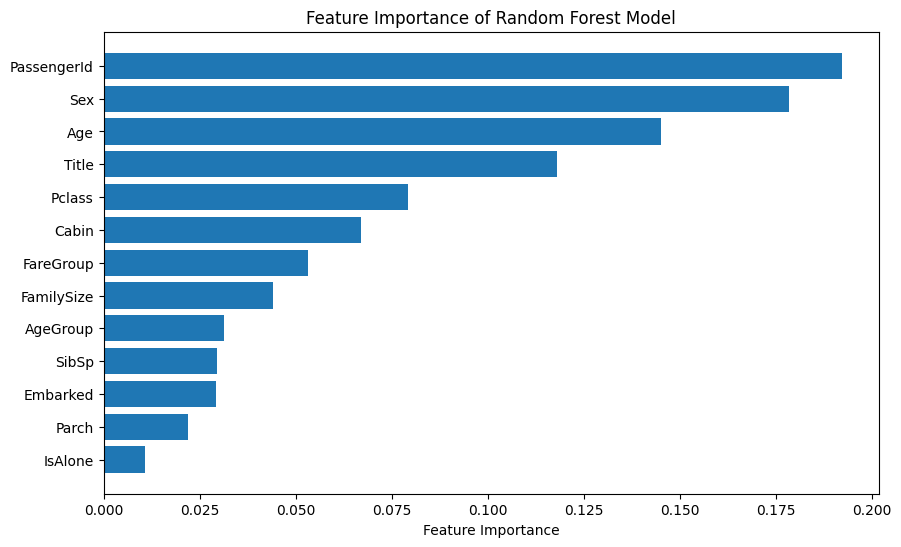

In [323]:
# Get feature importances
feature_importance = rfc.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_idx = feature_importance.argsort()

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance of Random Forest Model')
plt.show()

In [324]:
submission=pd.read_csv('/kaggle/input/titanic/gender_submission.csv')


In [325]:
submission


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [327]:
print(submission.isnull().sum())


PassengerId    0
Survived       0
dtype: int64


In [328]:
print(submission.dtypes)


PassengerId    int64
Survived       int64
dtype: object


In [329]:

submission = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': test_predictions})

In [330]:
submission.shape

(418, 2)

In [331]:
submission.to_csv('submission.csv', index=False)